In [1229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [1230]:
df=pd.read_csv('train.csv')



In [1231]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

df['SalePrice'].mean()
    

np.float64(180921.19589041095)

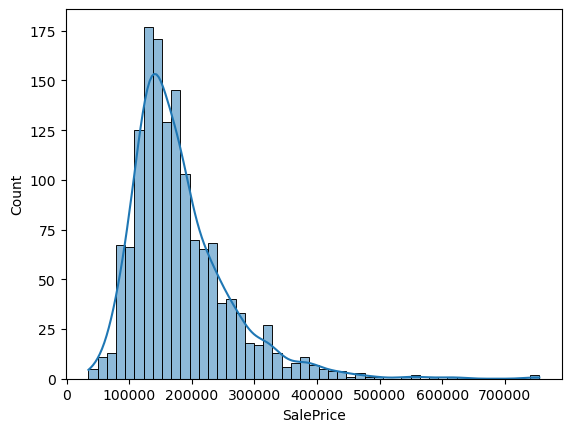

In [1232]:
sns.histplot(df,x='SalePrice',kde=True)
plt.show()

In [1233]:
df=df.drop(columns=['Id','Alley','PoolQC','Fence','MiscFeature'])
df=df.dropna(subset=['MasVnrArea','Electrical'])


In [1234]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

In [1235]:
num=[]
for col in list(count.index):
    if df[col].dtype!='object':
        num.append(col)

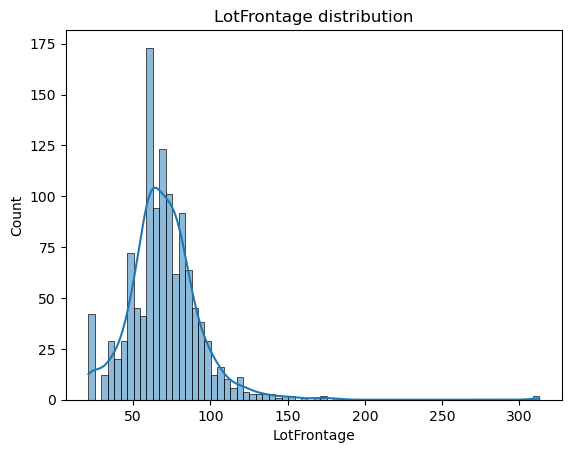

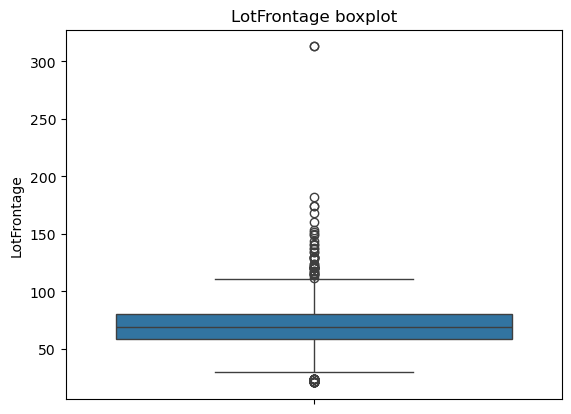

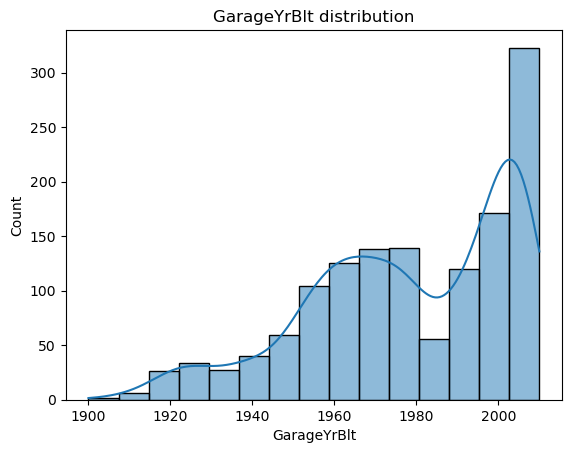

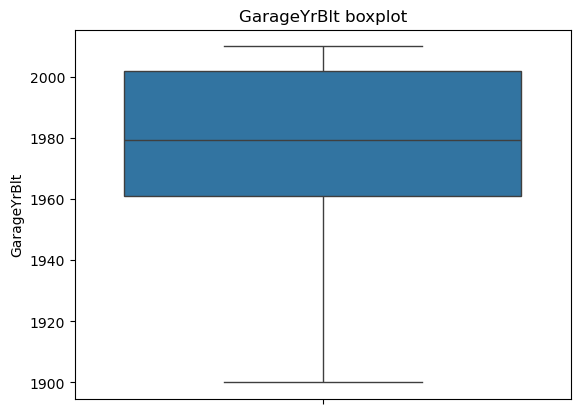

In [1236]:
for n in num:
    sns.histplot(df[n],kde=True)
    plt.title(f'{n} distribution')
    plt.show()
    sns.boxplot(df[n])
    plt.title(f'{n} boxplot')
    plt.show()

In [1237]:
from sklearn.impute import SimpleImputer
mean_impute=SimpleImputer(strategy='mean')
median_impute=SimpleImputer(strategy='median')
df['LotFrontage']=median_impute.fit_transform(df[[num[0]]])
df[num[1]]=mean_impute.fit_transform(df[[num[1]]])

In [1238]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(exclude=['object']).columns
preprocessor=ColumnTransformer(transformers=[
    ('cat',OneHotEncoder(sparse_output=False),cat_cols),
    ('num','passthrough',num_cols)
])
df_encoded=preprocessor.fit_transform(df)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([ohe_feature_names, num_cols])
df_encoded = pd.DataFrame(df_encoded, columns=all_feature_names, index=df.index)

In [1239]:
 
from sklearn.impute import KNNImputer

knnimputer=KNNImputer(n_neighbors=23)
df_imp=knnimputer.fit_transform(df_encoded)
df_encoded=pd.DataFrame(df_imp,columns=df_encoded.columns,index=df_encoded.index)

In [1240]:
x=df_encoded.drop('SalePrice',axis=1)
y=np.log1p(df_encoded['SalePrice'])

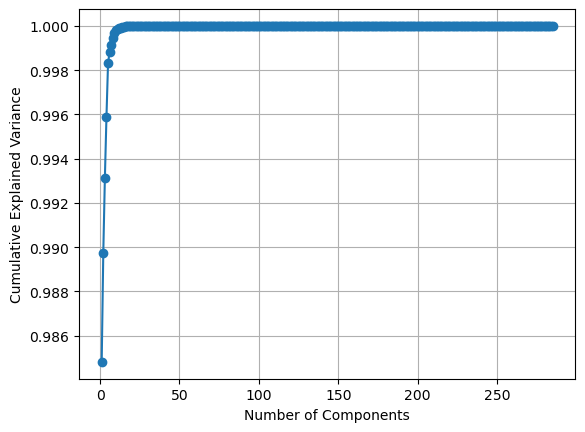

In [1241]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(x)
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

In [1242]:
pca=PCA(n_components=15)
x=pca.fit_transform(x)

In [1243]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchmetrics import MeanSquaredError


In [1244]:
class MyDataset(Dataset):
    def __init__(self,feature,target):
        self.x=torch.tensor(feature,dtype=torch.float32)
        self.y=torch.tensor(target.values.astype(np.float32),dtype=torch.float32).view(-1,1)
    def __getitem__(self, index):
        return self.x[index],self.y[index]
    def __len__(self):
        return self.x.shape[0]
class Net(nn.Module):
    def __init__(self,n_features):
        super().__init__()
        self.layer=nn.Sequential(
            nn.Linear(n_features,256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            
            nn.Linear(256,128),
            nn.ReLU(),
            
            nn.Linear(128,1)
        )
    def forward(self,x):
        return self.layer(x)


In [1245]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=18)

In [1246]:

train_data=MyDataset(x_train,y_train)
train=DataLoader(train_data,batch_size=64,shuffle=True)
model=Net(x.shape[1])
criterion=nn.SmoothL1Loss()
optim=optim.Adam(model.parameters(),lr=0.005)


In [1247]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer): Sequential(
    (0): Linear(in_features=15, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [1248]:
loss_list=[]
for epoch in range(400):
    model.train()
    running_loss=0
    total_samples=0
    for features,labels in train:
        features=features.to(device)
        labels=labels.to(device)
        optim.zero_grad()
        outputs=model(features)
        loss=criterion(outputs,labels)
        loss.backward()
        optim.step()
        running_loss+=np.sqrt(loss.item()*labels.size(0))
        total_samples+=labels.size(0)
    epoch_loss=running_loss/total_samples
    loss_list.append(epoch_loss)
    


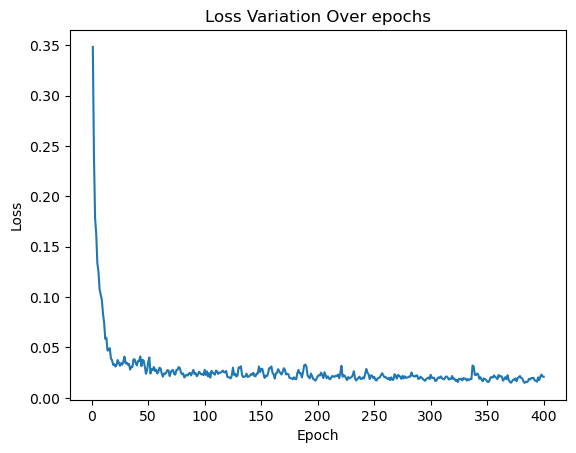

In [1249]:
lossdf=pd.DataFrame({'epoch':list(range(1,401)),'loss':loss_list})
sns.lineplot(lossdf,x='epoch',y='loss')
plt.title('Loss Variation Over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [1250]:
test_data=MyDataset(x_test,y_test)
test=DataLoader(test_data,batch_size=32,shuffle=True)
mse=MeanSquaredError().to(device)
model.eval()
with torch.no_grad():
    for features,target in test:
        features=features.to(device)
        target=target.to(device)
        outputs=model(features)
        outputs=torch.expm1(outputs)
        target=torch.expm1(target)
        mse.update(outputs,target)
    mse_value=mse.compute()
    rmse_value=torch.sqrt(mse_value)
print(rmse_value)
rmse_value=rmse_value/df['SalePrice'].mean()*100
print(f'My model is ~{rmse_value:.2f}% off an average')

tensor(41228.5586, device='cuda:0')
My model is ~22.83% off an average
